# Bulk Import to Load the Necessary Libraries 

In [76]:
import pymysql
import pandas as pd
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import wikipedia
import spacy
from textblob import TextBlob
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from scipy import sparse
from sklearn.metrics import pairwise_distances

# Project Goal 

The goal of this project is to implement a machine learning model to provide restaurant recommendations to users based on prior reviews and preferences. In the long term the model can be applied to other categories of businesses like 'Hair Salons', 'Coffee Shops' and so on 

# Proposed Methods and Models 

The recommender system is going to be implemented using the following approaches 
1. Collaborative Filtering Mechanism 
2. Content Based Filtering Mechanism 
3. Hybrid approach 

# Risk

1. Personally, everything I am doing in this topic is new to me. Hence I am learning as I go 
2. Might need more computing power (either an AWS or some other cloud hosted solution) to run the model
3. Still trying to figure out the best evaluation methods for the recommender system

# Assumption 

There is almost an overload of data. Hence, we will have to parse out some section of the dats while building and testing the model 

# Initial Goals

1. Retrieve the data from yelp 
2. Set up a MYSQL instance to load the SQL version of the data 
3. Load the data from MYSQL to Pandas for further analysis 
4. Perform some basic EDA on the important features
5. Build out a simple Collaborative model 
6. Build out a simple Content based model 
7. Using 5 & 6 build out a hydrid model 
8. Test the model for accurancy 

**Stretch Goal:**  Build out a UI for the model in either flask or Tkinter. 


# Setting up the connection for MYSQL 

In [3]:
conn = pymysql.connect(host='localhost', port=3306, user='root', passwd='test123', db='mysql')
cur = conn.cursor()

# Loading up the DataFrames from MYSQL

In [4]:
business_df = pd.read_sql('select * from yelp_db.business', con=conn)

In [5]:
user_df = pd.read_sql('select * from yelp_db.user', con=conn)

In [6]:
review_df = pd.read_sql('select * from yelp_db.review', con=conn)

In [7]:
category_df = pd.read_sql('select * from yelp_db.category', con=conn)

In [8]:
attribute_df = pd.read_sql('select * from yelp_db.attribute', con=conn)

In [9]:
checkin_df = pd.read_sql('select * from yelp_db.checkin', con=conn)

In [10]:
tip_df = pd.read_sql('select * from yelp_db.tip', con=conn)

In [11]:
eliteyears_df = pd.read_sql('select * from yelp_db.elite_years', con=conn)

In [12]:
friend_df = pd.read_sql('select * from yelp_db.friend', con=conn)

In [13]:
hours_df = pd.read_sql('select * from yelp_db.hours', con=conn)

In [14]:
photo_df = pd.read_sql('select * from yelp_db.photo', con=conn)

In [15]:
'''Loading from my custom view '''
# user_review_business = pd.read_sql('select * from yelp_db.v_user_revew_business',  con=conn)

'Loading from my custom view '

# Intial Data Validation - Descriptive Analysis

# Business 

In [16]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156639 entries, 0 to 156638
Data columns (total 12 columns):
id              156639 non-null object
name            156639 non-null object
neighborhood    156639 non-null object
address         156639 non-null object
city            156639 non-null object
state           156639 non-null object
postal_code     156639 non-null object
latitude        156638 non-null float64
longitude       156638 non-null float64
stars           156639 non-null float64
review_count    156639 non-null int64
is_open         156639 non-null int64
dtypes: float64(3), int64(2), object(7)
memory usage: 14.3+ MB


In [17]:
business_df.head()

,id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open
0,--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.8409,-79.3996,3.0,30,1
1,--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,,16432 Old Statesville Rd,Huntersville,NC,28078,35.4371,-80.8437,4.0,42,1
2,--8LPVSo5i0Oo61X01sV9A,Valley Bone and Joint Specialists,,"3941 E Baseline Rd, Ste 102",Gilbert,AZ,85234,33.3795,-111.7280,4.5,3,1
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,The Strip,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.1232,-115.1690,4.0,1389,1
4,--9QQLMTbFzLJ_oT-ON3Xw,Great Clips,,"1835 E Guadalupe Rd, Ste 106",Tempe,AZ,85283,33.3617,-111.9100,3.0,9,1


The business dataframe list the details like business name, business id, address, rating, total number of reviews associated with the business, and the open flag. There are also ~156k business in the dataset

# User

In [18]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183362 entries, 0 to 1183361
Data columns (total 20 columns):
id                    1183362 non-null object
name                  1183362 non-null object
review_count          1183362 non-null int64
yelping_since         1183362 non-null datetime64[ns]
useful                1183362 non-null int64
funny                 1183362 non-null int64
cool                  1183362 non-null int64
fans                  1183362 non-null int64
average_stars         1183362 non-null float64
compliment_hot        1183362 non-null int64
compliment_more       1183362 non-null int64
compliment_profile    1183362 non-null int64
compliment_cute       1183362 non-null int64
compliment_list       1183362 non-null int64
compliment_note       1183362 non-null int64
compliment_plain      1183362 non-null int64
compliment_cool       1183362 non-null int64
compliment_funny      1183362 non-null int64
compliment_writer     1183362 non-null int64
compliment_photos  

In [19]:
user_df.head()

,id,name,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,---1lKK3aKOuomHnwAkAow,Monera,245,2007-06-04,67,22,9,15,3.97,2,3,2,1,0,5,9,9,9,9,0
1,---94vtJ_5o_nikEs6hUjg,Joe,2,2016-05-27,0,0,0,0,5.00,0,0,0,0,0,0,0,0,0,0,0
2,---cu1hq55BP9DWVXXKHZg,Jeb,57,2009-04-18,34,14,0,0,3.79,0,0,0,0,0,3,2,0,0,0,0
3,---fhiwiwBYrvqhpXgcWDQ,Jed,8,2011-04-20,2,3,1,0,2.78,0,0,0,0,0,0,0,0,0,0,0
4,---PLwSf5gKdIoVnyRHgBA,Rae,2,2015-07-31,1,0,0,0,4.00,0,0,0,0,0,0,0,0,0,0,0


The user dataset has attributes like user id, username, total number of reviews submitted by the user along with other user specific attributes. The dataset has close to 1.2 million users in the dataset

# Review

In [20]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250697 entries, 0 to 4250696
Data columns (total 9 columns):
id             object
stars          int64
date           datetime64[ns]
text           object
useful         int64
funny          int64
cool           int64
business_id    object
user_id        object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 291.9+ MB


In [21]:
review_df.head()

,id,stars,date,text,useful,funny,cool,business_id,user_id
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w
1,---0hl58W-sjVTKi5LghGw,4,2016-07-24,Ate the momos during the momo crawl.. Was the ...,0,0,0,Ae4ABFarGMaI5lk1i98A0w,Y6qylbHq8QJmaCRSlKdIog
2,---3OXpexMp0oAg77xWfYA,5,2012-04-07,Pizza here made my night... Good people and gr...,2,0,0,lKq4Qsz13FDcAVgp49uukQ,SnXZkRN9Yf060pNTk1HMDg
3,---65iIIGzHj96QnOh89EQ,5,2015-09-11,Great brisket sandwich as claimed. Weird that ...,0,0,0,6nKR80xEGHYf2UxAe_Cu_g,VcmSgvslHAhqWoEn16wjjw
4,---7WhU-FtzSUOje87Y4uw,5,2016-01-22,"Interesting food, great atmosphere, and great ...",1,1,1,Z_mJYg3vi8cPZHa1J4BALw,NKF9v-r0jd1p0JVi9h2T1w


This is probably the most important dataset along with users, business as it has most important features needed to build the recommender model. The dataset includes the individual reviews given by the user in terms of the star rating and the text review. The review also has a foreign key to join back to the business and users. The reviews dataset has close to 4.8 reviews across all categories of business

# Category

In [22]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590290 entries, 0 to 590289
Data columns (total 2 columns):
business_id    590290 non-null object
category       590290 non-null object
dtypes: object(2)
memory usage: 9.0+ MB


In [23]:
category_df.head()

,business_id,category
0,YDf95gJZaq05wvo7hTQbbQ,Shopping
1,YDf95gJZaq05wvo7hTQbbQ,Shopping Centers
2,mLwM-h2YhXl2NCgdS84_Bw,Food
3,mLwM-h2YhXl2NCgdS84_Bw,Soul Food
4,mLwM-h2YhXl2NCgdS84_Bw,Convenience Stores


In [24]:
print ('Distinct Category Count: ', len(category_df.category.value_counts()))

Distinct Category Count:  1240


In [25]:
category_df.category.value_counts()

Restaurants                  51613
Shopping                     24595
Food                         23014
Beauty & Spas                15139
Home Services                13202
Health & Medical             12033
Nightlife                    11364
Bars                          9868
Automotive                    9476
Local Services                9343
Event Planning & Services     8038
Active Life                   7427
Fashion                       6299
Sandwiches                    5864
Fast Food                     5792
American (Traditional)        5737
Pizza                         5652
Coffee & Tea                  5565
Hair Salons                   5395
Hotels & Travel               5188
Arts & Entertainment          5054
Home & Garden                 4584
Auto Repair                   4480
Italian                       4411
Burgers                       4236
Doctors                       4124
Breakfast & Brunch            4103
Mexican                       3913
Nail Salons         

This dataset has the business categories. Each business is tied to a category. There are 1240 distinct categories and the most common category is 'Restaurants'.  

In [26]:
'''Top 30 Categories'''
category_df.category.value_counts()[0:30]

Restaurants                  51613
Shopping                     24595
Food                         23014
Beauty & Spas                15139
Home Services                13202
Health & Medical             12033
Nightlife                    11364
Bars                          9868
Automotive                    9476
Local Services                9343
Event Planning & Services     8038
Active Life                   7427
Fashion                       6299
Sandwiches                    5864
Fast Food                     5792
American (Traditional)        5737
Pizza                         5652
Coffee & Tea                  5565
Hair Salons                   5395
Hotels & Travel               5188
Arts & Entertainment          5054
Home & Garden                 4584
Auto Repair                   4480
Italian                       4411
Burgers                       4236
Doctors                       4124
Breakfast & Brunch            4103
Mexican                       3913
Nail Salons         

# Attribute 

In [27]:
attribute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229805 entries, 0 to 1229804
Data columns (total 3 columns):
business_id    1229805 non-null object
name           1229805 non-null object
value          1229805 non-null object
dtypes: object(3)
memory usage: 28.1+ MB


In [28]:
attribute_df.head()

,business_id,name,value
0,YDf95gJZaq05wvo7hTQbbQ,RestaurantsPriceRange2,2
1,YDf95gJZaq05wvo7hTQbbQ,BusinessParking,"{""garage"": false, ""street"": false, ""validated""..."
2,YDf95gJZaq05wvo7hTQbbQ,BikeParking,1
3,YDf95gJZaq05wvo7hTQbbQ,WheelchairAccessible,1
4,mLwM-h2YhXl2NCgdS84_Bw,GoodForMeal,"{""dessert"": false, ""latenight"": false, ""lunch""..."


The attributes dataset has attributes of the business. 

# Hours 

In [29]:
hours_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
hours          0 non-null object
business_id    0 non-null object
dtypes: object(2)
memory usage: 0.0+ bytes


In [30]:
hours_df.head()

,hours,business_id


The hours dataet includes hours of operation for the specific business

# Tip

In [31]:
tip_df.head()

,user_id,business_id,text,date,likes


The tips dataet includes some valuable tips from the user on the business 

# Data Model 

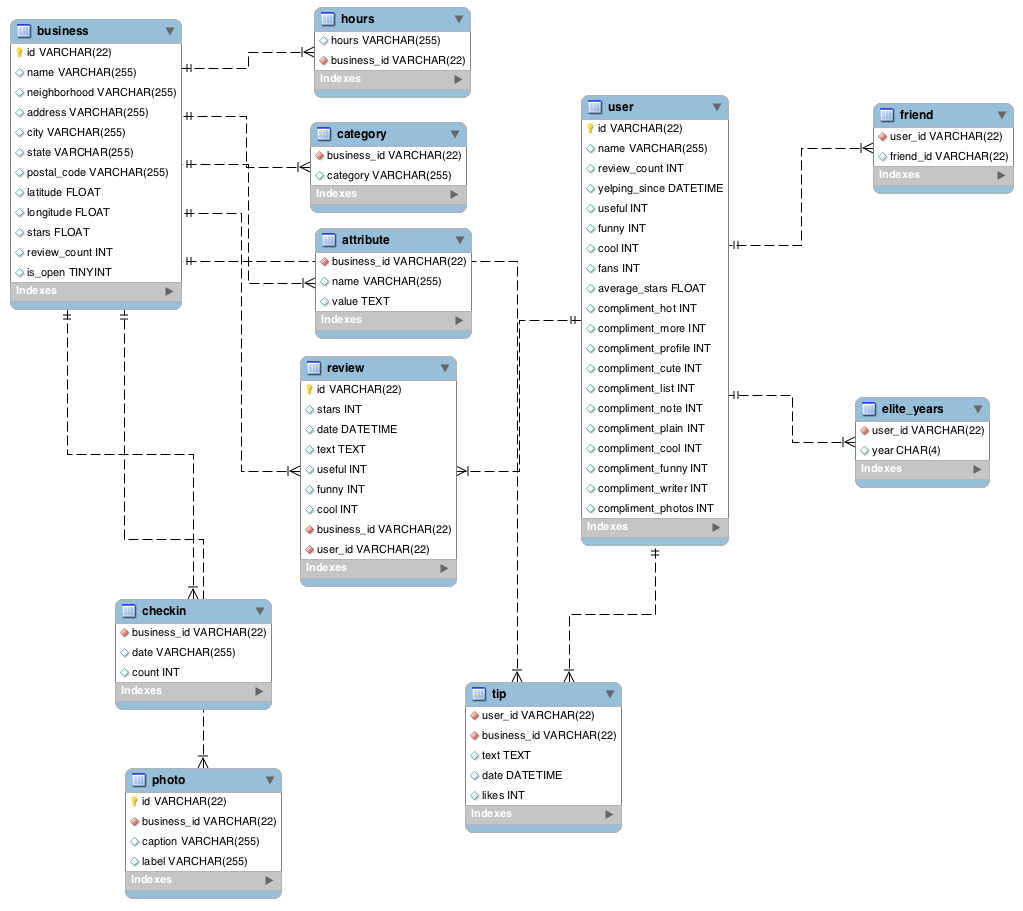

In [32]:
Image("https://s3-media2.fl.yelpcdn.com/assets/srv0/engineering_pages/9c5f7a89fd08/assets/img/dataset/yelp_dataset_schema.png")

Reviews, Users, Business and Categories are the most important datasets for us to build the model

# Data Pre-Processing

In [33]:
# restaurant_df = category_df.loc[category_df['category'] == 'Restaurants', : ]
# restaurant_df.head()

In [34]:
'''Renaming the column names in the Business Dataframes before the Merge '''

business_df.rename(columns={'id': 'business_id', 'name': 'business_name', 'address': 'business_address',\
                            'city': 'business_city', 'state': 'business_state',\
                            'postal_code': 'business_postal_code' , 'stars': 'business_stars',\
                            'review_count': 'business_review_count', 'is_open': 'business_isopen'}, inplace=True)

### Renaming Columns in the Business Dataframe

In [35]:
'''Reviewing the list of column names in the Business Dataframe'''

business_df.columns

Index(['business_id', 'business_name', 'neighborhood', 'business_address',
       'business_city', 'business_state', 'business_postal_code', 'latitude',
       'longitude', 'business_stars', 'business_review_count',
       'business_isopen'],
      dtype='object')

### Renaming Columns in the Review Dataframe

In [36]:
'''Renaming the column names in the Review Dataframes before the Merge '''

review_df.rename(columns={'id': 'review_id', 'stars': 'review_stars', 'date': 'review_date',\
                          'text': 'review_text', 'useful': 'review_useful', 'funny': 'review_funny',\
                          'cool': 'review_cool'}, inplace = True)

In [37]:
'''Reviewing the list of columns in the Review Dataframe'''

review_df.columns

Index(['review_id', 'review_stars', 'review_date', 'review_text',
       'review_useful', 'review_funny', 'review_cool', 'business_id',
       'user_id'],
      dtype='object')

## Step 1 Merge: Reviews and Business

In [38]:
review_business = pd.merge(review_df, business_df, on='business_id' )

In [39]:
review_business.head()

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,neighborhood,business_address,business_city,business_state,business_postal_code,latitude,longitude,business_stars,business_review_count,business_isopen
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
1,-xWKdp-WwOqH0wmgRRUDAw,5,2015-10-12,I love this place. I worked at Red Robin 15 ye...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,1RfYkPg_zadobGQyGvv_sA,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
2,09uUEX7YK9DGqpZOVlZhMA,3,2013-05-17,Dear Yelp... half stars....pleeeeeeease!\n\nAn...,0,2,0,Ue6-WhXvI-_1xUIuapl0zQ,hh2jrSklEfM9Dw5q3rxP3g,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
3,0SejaV1xUpswVYIZKhW0vA,2,2016-03-26,Today would be my third time ever eating at a ...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,Y1CHpv6YJ6hNXVNTjcM6Mw,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
4,1XC3dV9lzobiN3ZWZevP6Q,4,2017-02-18,"Sometimes you just want an good burger, or at ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,FJH32jg-8ZKIrZLPfZX_Ww,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1


### Renaming the columns in the Users Dataframe

In [40]:
user_df.rename(columns={'id': 'user_id', 'name': 'user_name', 'review_count': 'user_review_count',\
                       'yelping_since': 'user_yelping_since'}, inplace=True)

In [41]:
user_df_short = user_df[['user_id', 'user_name', 'user_review_count', 'user_yelping_since']]
user_df_short['user_id_name'] = user_df_short['user_name'] + user_df_short['user_id']
user_df_short.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,user_name,user_review_count,user_yelping_since,user_id_name
0,---1lKK3aKOuomHnwAkAow,Monera,245,2007-06-04,Monera---1lKK3aKOuomHnwAkAow
1,---94vtJ_5o_nikEs6hUjg,Joe,2,2016-05-27,Joe---94vtJ_5o_nikEs6hUjg
2,---cu1hq55BP9DWVXXKHZg,Jeb,57,2009-04-18,Jeb---cu1hq55BP9DWVXXKHZg
3,---fhiwiwBYrvqhpXgcWDQ,Jed,8,2011-04-20,Jed---fhiwiwBYrvqhpXgcWDQ
4,---PLwSf5gKdIoVnyRHgBA,Rae,2,2015-07-31,Rae---PLwSf5gKdIoVnyRHgBA


## Step 2 Merge: Review, Business and Users 

In [42]:
review_business_users = pd.merge(review_business, user_df_short, on= 'user_id')

In [43]:
review_business_users.head()

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,...,business_postal_code,latitude,longitude,business_stars,business_review_count,business_isopen,user_name,user_review_count,user_yelping_since,user_id_name
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,Red Robin Gourmet Burgers,...,85323,33.4652,-112.281,3.0,104,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
1,Ch464kMu7MGRg-Xvb3j2aw,3,2012-08-29,"I'm not sure which came first, Postino's or St...",3,2,0,z6-reuC5BYf_Rth9gMBfgQ,gVmUR8rqUFdbSeZbsg6z_w,St. Francis Restaurant,...,85012,33.5090,-112.071,4.0,1273,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
2,LhUiilxYwQDzaKI5oFnkBw,5,2011-12-14,Wow. and I'll say it again. Wow. I felt like s...,0,0,0,5LNZ67Yw9RD6nf4_UhXOjw,gVmUR8rqUFdbSeZbsg6z_w,The Cosmopolitan of Las Vegas,...,89109,36.1097,-115.174,4.0,3621,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
3,moMY7HlKwk9HWgACnty_cQ,4,2012-08-29,Unique and fun new place in Scottsdale! Took t...,0,0,0,OY0-hYJ2q6WiAqhYnCZZ0w,gVmUR8rqUFdbSeZbsg6z_w,Brat Haus,...,85251,33.4900,-111.926,4.0,587,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
4,bOOTnO1PeKJ6ms3-b8sWSA,5,2015-12-27,Wow. \n\nFor quite a long time I've avoided Pi...,2,1,1,pSQFynH1VxkfSmehRXlZWw,gVmUR8rqUFdbSeZbsg6z_w,Pizzeria Bianco,...,85004,33.4492,-112.066,4.0,1899,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w


In [44]:
review_business_users.head()

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,...,business_postal_code,latitude,longitude,business_stars,business_review_count,business_isopen,user_name,user_review_count,user_yelping_since,user_id_name
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,Red Robin Gourmet Burgers,...,85323,33.4652,-112.281,3.0,104,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
1,Ch464kMu7MGRg-Xvb3j2aw,3,2012-08-29,"I'm not sure which came first, Postino's or St...",3,2,0,z6-reuC5BYf_Rth9gMBfgQ,gVmUR8rqUFdbSeZbsg6z_w,St. Francis Restaurant,...,85012,33.5090,-112.071,4.0,1273,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
2,LhUiilxYwQDzaKI5oFnkBw,5,2011-12-14,Wow. and I'll say it again. Wow. I felt like s...,0,0,0,5LNZ67Yw9RD6nf4_UhXOjw,gVmUR8rqUFdbSeZbsg6z_w,The Cosmopolitan of Las Vegas,...,89109,36.1097,-115.174,4.0,3621,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
3,moMY7HlKwk9HWgACnty_cQ,4,2012-08-29,Unique and fun new place in Scottsdale! Took t...,0,0,0,OY0-hYJ2q6WiAqhYnCZZ0w,gVmUR8rqUFdbSeZbsg6z_w,Brat Haus,...,85251,33.4900,-111.926,4.0,587,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w
4,bOOTnO1PeKJ6ms3-b8sWSA,5,2015-12-27,Wow. \n\nFor quite a long time I've avoided Pi...,2,1,1,pSQFynH1VxkfSmehRXlZWw,gVmUR8rqUFdbSeZbsg6z_w,Pizzeria Bianco,...,85004,33.4492,-112.066,4.0,1899,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w


In [45]:
review_business_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4250697 entries, 0 to 4250696
Data columns (total 24 columns):
review_id                object
review_stars             int64
review_date              datetime64[ns]
review_text              object
review_useful            int64
review_funny             int64
review_cool              int64
business_id              object
user_id                  object
business_name            object
neighborhood             object
business_address         object
business_city            object
business_state           object
business_postal_code     object
latitude                 float64
longitude                float64
business_stars           float64
business_review_count    int64
business_isopen          int64
user_name                object
user_review_count        int64
user_yelping_since       datetime64[ns]
user_id_name             object
dtypes: datetime64[ns](2), float64(3), int64(7), object(12)
memory usage: 810.8+ MB


### Renaming the columns in the Categories Dataframe 

In [46]:
category_df.rename(columns={'category': 'category_name'}, inplace=True)

In [47]:
'''Extracting the list of Restaurant Categories only'''
restaurant_category = category_df.loc[category_df['category_name'] == 'Restaurants',:]
restaurant_category.head()

,business_id,category_name
5,mLwM-h2YhXl2NCgdS84_Bw,Restaurants
11,duHFBe87uNSXImQmvBh87Q,Restaurants
54,SDMRxmcKPNt1AHPBKqO64Q,Restaurants
59,iFEiMJoEqyB9O8OUNSdLzA,Restaurants
76,HmI9nhgOkrXlUr6KZGZZew,Restaurants


## Step 3 Merge: Review, Business, Users and Categories 

In [48]:
review_business_users_category = pd.merge(review_business_users, restaurant_category, on = 'business_id')

In [49]:
review_business_users_category.head()

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,...,latitude,longitude,business_stars,business_review_count,business_isopen,user_name,user_review_count,user_yelping_since,user_id_name,category_name
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,Red Robin Gourmet Burgers,...,33.4652,-112.281,3.0,104,1,Beth,484,2009-01-02,BethgVmUR8rqUFdbSeZbsg6z_w,Restaurants
1,-xWKdp-WwOqH0wmgRRUDAw,5,2015-10-12,I love this place. I worked at Red Robin 15 ye...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,1RfYkPg_zadobGQyGvv_sA,Red Robin Gourmet Burgers,...,33.4652,-112.281,3.0,104,1,Jon,24,2015-09-13,Jon1RfYkPg_zadobGQyGvv_sA,Restaurants
2,09uUEX7YK9DGqpZOVlZhMA,3,2013-05-17,Dear Yelp... half stars....pleeeeeeease!\n\nAn...,0,2,0,Ue6-WhXvI-_1xUIuapl0zQ,hh2jrSklEfM9Dw5q3rxP3g,Red Robin Gourmet Burgers,...,33.4652,-112.281,3.0,104,1,Miss,138,2010-06-02,Misshh2jrSklEfM9Dw5q3rxP3g,Restaurants
3,0SejaV1xUpswVYIZKhW0vA,2,2016-03-26,Today would be my third time ever eating at a ...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,Y1CHpv6YJ6hNXVNTjcM6Mw,Red Robin Gourmet Burgers,...,33.4652,-112.281,3.0,104,1,Vee,40,2014-12-23,VeeY1CHpv6YJ6hNXVNTjcM6Mw,Restaurants
4,1XC3dV9lzobiN3ZWZevP6Q,4,2017-02-18,"Sometimes you just want an good burger, or at ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,FJH32jg-8ZKIrZLPfZX_Ww,Red Robin Gourmet Burgers,...,33.4652,-112.281,3.0,104,1,Tim,228,2007-05-28,TimFJH32jg-8ZKIrZLPfZX_Ww,Restaurants


In [50]:
'''Reviewing the final set of columns that is in our merged dataframe'''
review_business_users_category.columns

Index(['review_id', 'review_stars', 'review_date', 'review_text',
       'review_useful', 'review_funny', 'review_cool', 'business_id',
       'user_id', 'business_name', 'neighborhood', 'business_address',
       'business_city', 'business_state', 'business_postal_code', 'latitude',
       'longitude', 'business_stars', 'business_review_count',
       'business_isopen', 'user_name', 'user_review_count',
       'user_yelping_since', 'user_id_name', 'category_name'],
      dtype='object')

On quick review we notice a few important columns like review_stars, user_name, business_name, business_state, business_city.  

### Performing some quick EDA to see the list of States in the dataset 

In [51]:
review_business_users_category['business_state'].value_counts()

NV     852375
AZ     751321
ON     372156
NC     162011
OH     138928
PA     128811
QC      88700
WI      61997
BW      22338
EDH     21390
IL      19889
SC       5361
MLN       989
HLD       538
C         148
ELN        98
FIF        96
NYK        94
WLN        79
NY         63
NI         52
WA         37
PKN        22
01         20
ST         19
ESX         9
BY          8
RCC         7
KHL         6
XGL         5
3           5
WHT         4
HH          4
ABE         3
ZET         3
CA          3
Name: business_state, dtype: int64

# Extracting the Restaurants in the state of WI

For the purposes of building out the initial model we are going to extract out the restaurants in the state of Wisconsin alone. i.e. (business_state == 'WI') 

In [52]:
review_wi = review_business_users_category.loc[review_business_users_category['business_state']  == 'WI', :]

#### Reviewing the number of restaurants in the WI area

In [53]:
'''Validating the number of restaurants in the WI area'''
print ('Total Number of Restaurants in the selected Dataset: ', len(review_wi.business_name.unique()))

Total Number of Restaurants in the selected Dataset:  1203


In [54]:
'''List of 100 Restaurants in the selected Dataset'''
list(review_wi.business_name.unique())[0:100]

['La Bamba',
 "Ian's Pizza",
 "Lazy Jane's",
 'Forequarter',
 'Heritage Tavern',
 'A Pig In a Fur Coat',
 'Graze',
 'Daisy Cafe & Cupcakery',
 '4&20 Bakery & Cafe',
 "L'Etoile",
 'The Green Owl Cafe',
 'Tornado',
 'Fromagination',
 'La Taguara',
 'Vintage Brewing Co',
 'Natural Juice',
 "Louisianne's",
 "Johnny's Italian Steakhouse",
 'Claddagh Irish Pub',
 "Sprecher's Restaurant and Pub",
 'The Village Green Bar & Grill',
 "Tanner's Bar and Grill",
 "Friday's",
 'Roman Candle Pizzeria',
 'Cento',
 'The Old Fashioned',
 'Novanta',
 "Michael's Frozen Custard",
 'Grumpy Troll Pub & Brewery',
 'The Great Dane',
 'Fresco',
 'Journey Sushi & Seafood Buffet',
 'Red',
 'Norske Nook Restaurant & Bakery',
 'Dhaba Indian Bistro',
 'Noodles & Company',
 'Pancake Cafe',
 'Eldorado Grill',
 "Salvatore's Tomato Pies",
 'Sujeo',
 'Lucille',
 'Buraka Restaurant',
 "Schubert's Downtown Restaurant",
 "Paul's Pel'meni",
 'The Red Zone Madison',
 'Essen Haus',
 'Roast Public House',
 'Ramen Kid',
 'Himal 

### Reviewing the list of reviews in the dataset 

In [55]:
'''Validating the number of reviews'''
print ('Total Number of reviews in the selected Dataset: ', len(review_wi.review_id.unique()))

Total Number of reviews in the selected Dataset:  61997


Now that we have the data in a decent shape and form, we can start of by building out a simple model. One of the simpler models with recommender systems is the collaborative filtering model.

# Creating the Sparse Matrix for Collaborative Filtering

In [56]:
sparse_m = review_wi.pivot_table(index='user_id', columns='business_name', values='review_stars')

In [57]:
sparse_m.head(20)

business_name,1847 At the Stamm House,1855 Saloon and Grill,4&20 Bakery & Cafe,43 North,4B Cafe,5th Quarter Sports Bar & Grill,608 Restaurant and Bar,608 Sports Bar & Restaurant,8 Seasons Grille,A La Brasa Mexican Grill,...,Yummy Buffet,Zandru's,Zen Sushi,ZenZen Taste ???,Ziggy's BBQ Smokehouse & Ice Cream Parlor,Zizo Cafe,Zoe's Pizzeria,Zoup!,ZuZu Cafe & Market,wiener shop
user_id,,,,,,,,,,,,,,,,,,,,,
--JgEXWTirBKGOLHOBr0Wg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0-8dZP-jWAqamQ-dj2hLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-03_0o75vR4y_nD4vQnYXA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-03l1FfZrjW5VOr8MT6Yvg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0P9UGc_SAzFLe1YQb4bjQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0POfppeVjBx-9Bv1KbIiw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0ZDPWOe7yuKDaQcz3XUlw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0muMwSLdns0RO_CiZZr6g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-18LP5sg3N7CNYTu92xYBQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
sparse_m.shape

(20729, 1203)

In [59]:
sparse_m.fillna(0, inplace=True)
sparse_m.head()

business_name,1847 At the Stamm House,1855 Saloon and Grill,4&20 Bakery & Cafe,43 North,4B Cafe,5th Quarter Sports Bar & Grill,608 Restaurant and Bar,608 Sports Bar & Restaurant,8 Seasons Grille,A La Brasa Mexican Grill,...,Yummy Buffet,Zandru's,Zen Sushi,ZenZen Taste ???,Ziggy's BBQ Smokehouse & Ice Cream Parlor,Zizo Cafe,Zoe's Pizzeria,Zoup!,ZuZu Cafe & Market,wiener shop
user_id,,,,,,,,,,,,,,,,,,,,,
--JgEXWTirBKGOLHOBr0Wg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0-8dZP-jWAqamQ-dj2hLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-03_0o75vR4y_nD4vQnYXA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-03l1FfZrjW5VOr8MT6Yvg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0P9UGc_SAzFLe1YQb4bjQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
'''Top 20 Most Recommended Business'''
sparse_m.sum().sort_values(ascending=False)[0:20]

business_name
The Old Fashioned                       5077.0
Graze                                   2961.0
The Great Dane                          2432.0
Ha Long Bay Vietnamese & Thai Bistro    1950.0
Marigold Kitchen                        1708.0
Monty's Blue Plate Diner                1578.0
Salvatore's Tomato Pies                 1574.0
The Weary Traveler Freehouse            1553.0
Dotty Dumpling's Dowry                  1518.0
Tornado                                 1457.0
Merchant Madison                        1416.0
Bassett Street Brunch Club              1300.0
A Pig In a Fur Coat                     1294.0
Sardine                                 1284.0
Ian's Pizza                             1265.0
Paul's Pel'meni                         1225.0
Taqueria Guadalajara                    1219.0
DLUX                                    1202.0
Pizza Brutta                            1184.5
Heritage Tavern                         1147.0
dtype: float64

Text(0,0.5,'Review Count')

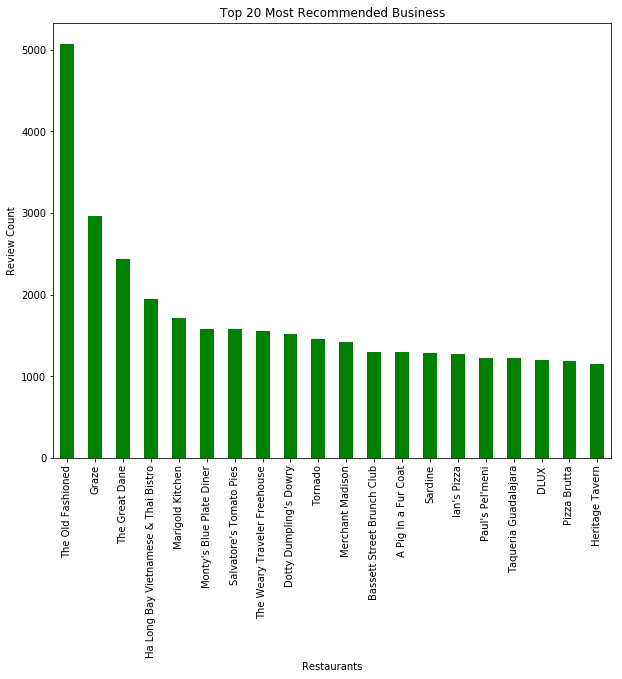

In [61]:
'''Top 20 Most Recommended Restaurants'''
sparse_m.sum().sort_values(ascending=False)[0:20].plot(kind='bar', color='g', figsize = (10,8))
plt.title('Top 20 Most Recommended Business')
plt.xlabel('Restaurants')
plt.ylabel('Review Count')

In [119]:
sparse_m.head()

business_name,1847 At the Stamm House,1855 Saloon and Grill,4&20 Bakery & Cafe,43 North,4B Cafe,5th Quarter Sports Bar & Grill,608 Restaurant and Bar,608 Sports Bar & Restaurant,8 Seasons Grille,A La Brasa Mexican Grill,A Pig In a Fur Coat,A Sakura,A&W Restaurant,A-OK Coffee,A8 China,AJ Bombers,AJ's Pizzeria and Diner,Abarrotes El Primo,Abuelo's,Ace's Main Tap,Adamah Neighborhood Table,Africana Restaurant and Lounge,Akari Sushi,Alchemy,Aldo's Cafe,Ale Asylum,All Stop Deforest,Alt' N Bach's Town Tap,Amber Indian Cuisine,America Latina,Amy's Cafe,Ancora Coffee,Angelic Brewing Co,Angelo's,Angelos,Angkor Wat,Anna's Pizzeria,Antojitos el Toril,Applebee's,Aranda's,Arbat,Arby's,Argus,Asahi Japanese Restaurant,Asia Express,Asian House,Asian Kitchen,Asian One,Asian Sweet Bakery,Athens Grill,Athens Gyros,Atlanta Bread Company,Atlantis Taverna,Avantis Italian Restaurant & Pub,Avenue Bar,Avenue Club and the Bubble Up Bar,Aztlan Mexican Grill,BB Jack's,BD's Mongolian Grill,BSR - Branch Street Retreat,Bab's French Quarter Kitchen,Babcock Hall Dairy Store,Babes Grill & Bar,Badger Bowl,Badger Tavern,Badgerland Bar & Grill,Bahn Thai Restaurant,Baldwin Street Grille,Bandung Indonesian Restaurant,Banushi's Bar and Grill,Banzo,Banzo Shük,Bar Bistro 608 / Rooftop Bar,Barolo Wine Bar,Barriques,Barriques - Monroe St.,Barriques - West Wash,Barriques Market,Barriques University,Basie's,Bassett Street Brunch Club,Bavaria Sausage,Beach House Restaurant & Lounge,Bean Sprouts Cafe,Bear & Bottle,Beef 'O' Brady's,Bella Roma,Bella Vita Italian Grille & Pizzeria,Belle Pizzelle European Bakery & Cafe,Belleville Ale House,Bellini Italian Restaurant,Bennett's Meadowood Country Club,Benvenuto's Italian Grill,Betty Lou Cruises,Biaggi's Ristorante Italiano,Biergarten at Olbrich Park,Big Apple Bagels,Big Red's Steaks,Big Sky,Bison Jacks,Bistro 101,Black Bear Inn,Black Locust Cafe,Blair Street BBQ & Catering,Blair Street Brew & BBQ,Blowin' Smoke BBQ,Blue Moon Bar & Grill,Blue Spoon Cafe,Bluephies,Bluephies Downtown Deli,Bob's BBQ Emporium,Bon Appetit Cafe,Bonefish Grill,Bonfyre American Grille,Borland's Tavern,Bourbon Street Grille,Bowl of Heaven,Bradbury's,Brasserie V,Brat und Brau,Breakwater,Brickhouse BBQ,Bridges Golf Course,Bristled Boar Saloon & Grill,Brocach,Brothers Three Bar & Grill,Brouxnellies Diner & Catering,Bruegger's Bagels,Bub's Burger Joint,Bubbles' Doubles,Bucatini,Buck & Badger,Buck & Honeys,Buck's Pizza,Buckingham's Bar & Grill,Buffalo Wild Wings,Bunky's Cafe,Buraka Restaurant,Burger King,Burgers + Ethnic Food + BBQ,Burrachos Fresh Mexican Grill,Burrito Drive,Byrd's Pub & Grill,Byrd's Pub and Grill,C's Restaurant Bakery and Coffee Shop,CHANG HUA GARDEN,CIRC,Cactus Ranch,Cafe Assisi,Cafe Continental,Cafe Costa Rica,Cafe Hollander,Cafe La Bellitalia,Cafe Maya,Cafe Montmartre,Cafe Porta Alba,Cafe Samba,Cafe Social,Cafe Soleil,Cafe Zupas,Cahoots Bar,Calasan,Callahan's Sports Pub,Campo di Bella,Campus Biryani & Gyros,Campus Inn,Cancun,Canteen,Capital Creamery,Capitol ChopHouse,Capriotti's Sandwich Shop,Captain Bill's,Cargo Coffee East,Carnival's,Casa Bianca,Casa De Lara,Casa Del Sol,Casa de Lara,Casbah Restaurant,Casetta Kitchen and Counter,Casey's General Store,Caspian Cafe & Catering,Cento,Chang Jiang,Chang Jiang Chinese Kitchen,Chang Jiang Chinese Restaurant,Chang Jiang Restaurant,Charley's Grilled Subs,Charlie's On Main,Chasers Bar & Grille,Chautara Restaurant,Cheba Hut,Cheese Melt Cafe,Cheeseburger in Paradise,Chez Nanou,Chi,Chick-fil-A,Chicken Lips,Chili King,Chili's,Chimmies,Chin's Asia Fresh,China Inn,China King,China Kitchen,China One West,China Palace,China Star,China Wok,Chipotle Mexican Grill,Chocolaterian Cafe,Christy's Landing,Chuck E. Cheese's,Churchkey Bar and Grill,Cilantro,City Bar,Claddagh Irish Pub,Cleveland's Diner,Club 5,Club Tavern & Grille,CoCoLiquot,Coach's Club,Cocina Real,Cold Fusion,Cold Stone Creamery,Colectivo Coffee,Come Back In,Common Pasta,Compadres Mexican Restaurant,Cool Beans Coffee Cafe,Copper Top Restaurant,Copps Fo

# Collaborative Filtering Model

#### Setting up the inputs for the model 

In [134]:
sparse_m.index

Index(['--JgEXWTirBKGOLHOBr0Wg', '-0-8dZP-jWAqamQ-dj2hLA', '-03_0o75vR4y_nD4vQnYXA', '-03l1FfZrjW5VOr8MT6Yvg', '-0P9UGc_SAzFLe1YQb4bjQ', '-0POfppeVjBx-9Bv1KbIiw', '-0ZDPWOe7yuKDaQcz3XUlw', '-0muMwSLdns0RO_CiZZr6g', '-18LP5sg3N7CNYTu92xYBQ', '-1EmUvmBM7kqlzRB218ljg',
       ...
       'zyeAIY6AH6PrFzWO-kGKvA', 'zyr8SvaTdMFkuF2lUs8-Mw', 'zys6uRHMc2EPF8I9UfG-SQ', 'zz5WHN_VGn5q0GI42NGvbw', 'zzDqIDPG6ZhywpnEeZdPsQ', 'zzGUguWplnzgKfYxM5KWsg', 'zzWBpLt0O8gf3Llw-aa7ag', 'zzZ1HJGNhhI7GqhHIzlPhA', 'zz_rsvdZTcIe-Q4sHYEy2w', 'zzbpcMZXHoZxUr9JZdH6wg'], dtype='object', name='user_id', length=20729)

In [135]:
restaurants_df = sparse_m.head(10)

In [136]:
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, --JgEXWTirBKGOLHOBr0Wg to -1EmUvmBM7kqlzRB218ljg
Columns: 1203 entries, 1847 At the Stamm House to wiener shop
dtypes: float64(1203)
memory usage: 94.1+ KB


In [137]:
restaurants_df.index

Index(['--JgEXWTirBKGOLHOBr0Wg', '-0-8dZP-jWAqamQ-dj2hLA', '-03_0o75vR4y_nD4vQnYXA', '-03l1FfZrjW5VOr8MT6Yvg', '-0P9UGc_SAzFLe1YQb4bjQ', '-0POfppeVjBx-9Bv1KbIiw', '-0ZDPWOe7yuKDaQcz3XUlw', '-0muMwSLdns0RO_CiZZr6g', '-18LP5sg3N7CNYTu92xYBQ', '-1EmUvmBM7kqlzRB218ljg'], dtype='object', name='user_id')

In [138]:
restaurants_df

business_name           1847 At the Stamm House  1855 Saloon and Grill  4&20 Bakery & Cafe  43 North  4B Cafe  5th Quarter Sports Bar & Grill  608 Restaurant and Bar  608 Sports Bar & Restaurant  8 Seasons Grille  A La Brasa Mexican Grill  A Pig In a Fur Coat  A Sakura  A&W Restaurant  A-OK Coffee  A8 China  AJ Bombers  AJ's Pizzeria and Diner  Abarrotes El Primo  Abuelo's  Ace's Main Tap  Adamah Neighborhood Table  Africana Restaurant and Lounge  Akari Sushi  Alchemy  Aldo's Cafe  Ale Asylum  All Stop Deforest  Alt' N Bach's Town Tap  Amber Indian Cuisine  America Latina  Amy's Cafe  Ancora Coffee  Angelic Brewing Co  Angelo's  Angelos  Angkor Wat  Anna's Pizzeria  Antojitos el Toril  Applebee's  Aranda's  Arbat  Arby's  Argus  Asahi Japanese Restaurant  Asia Express  Asian House  Asian Kitchen  Asian One  Asian Sweet Bakery  Athens Grill  Athens Gyros  Atlanta Bread Company  Atlantis Taverna  Avantis Italian Restaurant & Pub  Avenue Bar  Avenue Club and the Bubble Up Bar  Aztlan Mexican Grill  BB Jack's  BD's Mongolian Grill  BSR - Branch Street Retreat  Bab's French Quarter Kitchen  Babcock Hall Dairy Store  Babes Grill & Bar  Badger Bowl  Badger Tavern  Badgerland Bar & Grill  Bahn Thai Restaurant  Baldwin Street Grille  Bandung Indonesian Restaurant  Banushi's Bar and Grill  Banzo  Banzo Shük  Bar Bistro 608 / Rooftop Bar  Barolo Wine Bar  Barriques  Barriques - Monroe St.  Barriques - West Wash  Barriques Market  Barriques University  Basie's  \
user_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
--JgEXWTirBKGOLHOBr0Wg                      0.0                    0.0                 0.0       0.0      0.0                             0.0                     0.0                          0.0               0.0                       0.0                  0.0       0.0             0.0          0.0       0.0         0.0                      0.0                 0.0       0.0             0.0                        0.0                             0.0          0.0      0.0          0.0         0.0                0.0                     0.0                   0.0             0.0         0.0            0.0                 0.0       0.0      0.0         0.0              0.0                 0.0         0.0       0.0    0.0     0.0    0.0                        0.0           0.0          0.0            0.0        0.0                 0.0           0.0           0.0                    0.0               0.0                               0.0         0.0                                0.0                   0.0        0.0                   0.0      

In [139]:
user='-1EmUvmBM7kqlzRB218ljg'

### Item Item Collaborative Filtering 

In [140]:
'''Helper Functions for Item-Item Collaborative Filtering'''

'''Function to return the list of restaurants rated by the user'''
def user_rated_list(user):
    user_rated=[]
    for key, a_res in enumerate(list(restaurants_df.loc[user, :] ==0)):
        if a_res == False:
            user_rated.append((restaurants_df.loc[user, :] ==0).index[key])
        else: 
            continue
    return user_rated  


'''Function to return the list of restaurants yet to be rated by the user'''
def user_not_rated_list(user):
    user_not_rated=[]
    for key, a_res in enumerate(list(restaurants_df.loc[user, :] ==0)):
        if a_res == True:
            user_not_rated.append((restaurants_df.loc[user, :] ==0).index[key])
        else: 
            continue
    return (user_not_rated) 


'''Function to calculate the Co-Similarity'''
def cosim(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)


'''Function to calculate the co-sine similarity between the restaurants rated by the user and all the restaurants in the list'''
def cooccurence_matrix_creator():
    '''Calling the user rated function'''
    user_rated = user_rated_list(user)
    ur_rest_dict = {}
    for ur in user_rated: 
        ur_cosim=[]
        for ar in list(restaurants_df.columns): 
            similarity = cosim(restaurants_df[ur],\
                                            restaurants_df[ar])
            ur_cosim.append(similarity)
        ur_rest_dict[ur] = ur_cosim
    co_occurence_matrix = pd.DataFrame.from_dict(ur_rest_dict, orient='index')
    co_occurence_matrix.columns=list(restaurants_df.columns)
    return co_occurence_matrix

'''Function to create dataframe of the restaurants to be rated'''
def rest_to_rate(df):
    restaurants_to_rate = df[user_not_rated_list(user)]
    return restaurants_to_rate

# Predictor Function: Item-Item Predictor

In [141]:
'''Collaborative Item-Item filtering function to make predictions'''

def rating_predictor_colab_ii_all():
    
    predicted_rating_dict = {}
    
#     user_rated = user_rated_list(user)
#     user_not_rated = user_not_rated_list(user)
#     
    co_occurence_matrix = cooccurence_matrix_creator()
    restaurants_to_rate = rest_to_rate(co_occurence_matrix)
    
    for not_rated in restaurants_to_rate.columns: 
        column_df = pd.DataFrame(restaurants_to_rate[not_rated].sort_values(ascending=False))
        predicted_rating = []
        top_sim_list = []
        for top_n in range(2):   

            top_sim = column_df[not_rated][top_n]
            top_sim_list.append(top_sim)

            given_rr = column_df[not_rated].index[top_n]
            given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
            given_rank = given_rank_df.loc[given_rr,:]

            predicted_rating_item = float(given_rank*top_sim)
            predicted_rating.append(predicted_rating_item)
        total_sim_weight = sum(top_sim_list)
        adjusted_predicted_rating = (sum(predicted_rating))/total_sim_weight
        predicted_rating_dict[not_rated] = adjusted_predicted_rating
        
    '''Creating the Dataframe in this step'''
        
    predicted_df = pd.DataFrame.from_dict(predicted_rating_dict, orient='index')
    predicted_df.columns=[user]
    return predicted_df

In [143]:
'''Calling the predictor to make predictions'''
# predicted_df = rating_predictor_colab_ii_all()
# predicted_df.head()

'Calling the predictor to make predictions'

### User User Collaborative Filtering 

In [2]:
sparse_m['The Old Fashioned'].sort_values(ascending=False)

NameError: name 'sparse_m' is not defined